In [3]:
# 타자 EDA

%run ../data_tools.ipynb
%run ../create_metrics.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go
import xgboost
import shap

from mpl_toolkits.mplot3d import Axes3D
from statsmodels import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from plotly.offline import plot
from plotly.offline import init_notebook_mode


init_notebook_mode(connected = True)


C:\Users\jmp08\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\jmp08\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
crawled_player_batter = pd.read_csv("../Crawler/crawled_player_batter.csv")
crawled_player_pitcher = pd.read_csv("../Crawler/crawled_player_pitcher.csv")
crawled_team_batter = pd.read_csv("../Crawler/crawled_team_batter.csv")
crawled_team_pitcher = pd.read_csv("../Crawler/crawled_team_pitcher.csv")
crawled_csum_player_pitcher = pd.read_csv("../Crawler/crawled_csum_player_pitcher.csv")

crawled_player_batter = crawled_player_batter.drop(["TB"], axis = "columns")
crawled_team_batter = crawled_team_batter.drop(["TB", "START_CK"], axis = "columns")
crawled_player_pitcher = crawled_player_pitcher.drop(["WHIP"], axis = "columns")
crawled_team_pitcher = crawled_team_pitcher.drop(["WHIP"], axis = "columns")
crawled_csum_player_pitcher = crawled_csum_player_pitcher.drop(["WHIP", "MONEY", "AGE_VA", "NAME"], axis = "columns")

In [6]:
total_data = []
for i in list(range(2016, 2021)) :
    rawData = load_data(i)
    Scaling_Money(rawData["player"])
    rawData["player_batter"] = pd.merge(rawData["player_batter"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    rawData["player_pitcher"] = pd.merge(rawData["player_pitcher"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    
    rawData["player_batter"] = rawData["player_batter"][crawled_player_batter.columns]
    rawData["player_pitcher"] = rawData["player_pitcher"][crawled_player_pitcher.columns]
    rawData["team_batter"] = rawData["team_batter"][crawled_team_batter.columns]
    rawData["team_pitcher"] = rawData["team_pitcher"][crawled_team_pitcher.columns]
    rawData["csum_player_pitcher"] = rawData["csum_player_pitcher"][crawled_csum_player_pitcher.columns]
    
    if i == 2020 :
        rawData["player_batter"] = pd.concat([rawData["player_batter"], crawled_player_batter]).reset_index(drop = True)
        rawData["player_pitcher"] = pd.concat([rawData["player_pitcher"], crawled_player_pitcher]).reset_index(drop = True)
        rawData["team_batter"] = pd.concat([rawData["team_batter"], crawled_team_batter]).reset_index(drop = True)
        rawData["team_pitcher"] = pd.concat([rawData["team_pitcher"], crawled_team_pitcher]).reset_index(drop = True)
        rawData["csum_player_pitcher"] = pd.concat([rawData["csum_player_pitcher"], crawled_csum_player_pitcher]).reset_index(drop = True)
        
    make_batter_metrics(rawData, "player_batter")
    make_batter_metrics(rawData, "team_batter")
    make_pitcher_metrics(rawData, "player_pitcher")
    make_pitcher_metrics(rawData, "team_pitcher")
    total_data.append(rawData)

tableList = []
for key in total_data[0].keys() :
    tableList.append(key)

final_data = dict()
for key in tableList :
    final_data[key] = pd.DataFrame()

for year in range(len(total_data)) :
    for key in tableList :
        if final_data[key].empty :
            final_data[key] = total_data[year][key]
        else :
            final_data[key] = pd.concat([final_data[key], total_data[year][key]], axis = 0)
            
for key in final_data.keys() :
    final_data[key].reset_index(drop = True)

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [7]:
# 세이버 메트릭스 대부분의 지표는 선수 개인을 대상으로 합니다.
# 예측은 팀 단위로 이루어지기 때문에 선수 데이터를 바탕으로 팀을 대표할 수 있도록
# 각 선수의 세이버 메트릭스 지표에 대해 타자의 경우 타석 수, 투수의 경우 이닝 수를 기준으로
# 경기 별 각 선수의 가중 평균을 해당 경기의 팀 스탯으로 나타냈습니다.

final_data["player_batter"].rename(columns = {"MONEY" : "MONEY_BAT", "AGE_VA" : "AGE_VA_BAT"}, inplace = True)

metrics_batter = ["K/PA", "OPS", "ISO", "BABIP_BAT", "XR", "XR27", "EQA",
                  "wOBA", "wRAA", "wRC", "wRC+", "BA", "MONEY_BAT", "AGE_VA_BAT"]

original_stats_batter = ["PA", "AB", "RBI", "RUN", "HIT", "H2", "H3", "HR", "SB", "CS", "SH", "SF",
                         "BB", "IB", "HP", "KK", "GD", "ERR", "LOB"]

final_data["player_batter"] = final_data["player_batter"].sort_values(by = ["T_ID", "GDAY_DS", "HEADER_NO"]).reset_index(drop = True)

final_data["player_batter"] = final_data["player_batter"].loc[final_data["player_batter"]["PA"] != 0].reset_index(drop = True)

result = final_data["player_batter"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"])["PA"].sum()
result = result.to_frame().dropna().reset_index()
result.rename(columns = {"PA" : "PA_SUM"}, inplace = True)

final_data["player_batter"] = pd.merge(final_data["player_batter"], result)
final_data["player_batter"][metrics_batter] = final_data["player_batter"][metrics_batter].mul((final_data["player_batter"]["PA"] / 
                                                                                               final_data["player_batter"]["PA_SUM"]), axis = 0)
final_data["player_batter"] = final_data["player_batter"].drop("PA_SUM", axis = "columns")
final_data["player_batter"]

,GDAY_DS,BAT_ORDER_NO,START_CK,AB,RUN,HIT,H2,H3,HR,RBI,...,BABIP_BAT,BPF,XR,XR27,EQA,wOBA,wRAA,wRC,wRC+,BA
0,20160401,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.019231,NaN,0.009615,inf,0.038462,0.018154,0.010814,0.012699,NaN,0.019231
1,20160401,9,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.019231,1.103095,0.015769,0.425769,0.038462,0.018154,0.009278,0.017958,11.672637,0.019231
2,20160401,7,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.898473,-0.000462,-0.002492,0.048077,0.017238,-0.118677,-0.036039,-86.712513,0.000000
3,20160401,5,1.0,6.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.038462,0.863474,0.099231,0.669808,0.096154,0.042635,0.014578,0.101667,24.702673,0.038462
4,20160401,2,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.909278,-0.064154,-0.288692,0.000000,0.000000,-0.217886,-0.132749,-164.594026,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78356,20200923,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.791053,0.007083,inf,0.031250,0.015229,0.006969,0.009736,7.765027,NaN
78357,20200923,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.020833,0.787333,0.015000,inf,0.062500,0.026750,0.016955,0.019691,15.435568,0.020833
78358,20200923,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.786967,-0.002042,-0.055125,0.000000,0.000000,-0.006306,-0.003570,-2.274062,0.000000
78359,20200923,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.777914,-0.001875,-0.050625,0.000000,0.000000,-0.006306,-0.003570,-2.255202,0.000000


In [8]:
final_data["player_batter"].describe()

,GDAY_DS,BAT_ORDER_NO,START_CK,AB,RUN,HIT,H2,H3,HR,RBI,...,BABIP_BAT,BPF,XR,XR27,EQA,wOBA,wRAA,wRC,wRC+,BA
count,7.836100e+04,78361.000000,78361.000000,78361.000000,78361.000000,78361.000000,78361.000000,78361.000000,78361.000000,78361.000000,...,71763.000000,17832.000000,78361.000000,7.834200e+04,78342.000000,78184.000000,78184.000000,78184.000000,17782.000000,76747.000000
mean,2.017967e+07,5.188755,0.788211,3.044908,0.448897,0.854928,0.150483,0.013029,0.087684,0.435804,...,0.029438,0.866440,0.047495,inf,0.068266,0.030097,0.002977,0.049022,13.597512,0.024559
std,1.386144e+04,2.624975,0.408579,1.368103,0.685588,0.917548,0.388934,0.114632,0.303639,0.842537,...,0.030942,0.104636,0.079979,NaN,0.064407,0.028076,0.092082,0.099042,74.047362,0.025594
min,2.016040e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.322391,-0.180848,-9.765818e-01,0.000000,0.000000,-0.725702,-0.409245,-520.001283,0.000000
25%,2.017050e+07,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.791818,-0.002647,-6.750000e-02,0.000000,0.000000,-0.048157,-0.005863,-23.326237,0.000000
50%,2.018053e+07,5.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.027027,0.861491,0.022200,2.971957e-01,0.054054,0.024865,-0.007569,0.016241,-1.594534,0.025000
75%,2.019071e+07,8.000000,1.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.050000,0.929228,0.085870,1.304827e+00,0.107143,0.048314,0.043087,0.096845,46.244724,0.039683
max,2.020092e+07,9.000000,1.000000,7.000000,5.000000,5.000000,3.000000,3.000000,4.000000,8.000000,...,0.205128,2.148740,0.708750,inf,0.500000,0.191851,0.702379,0.858299,642.716091,0.137931


In [9]:
# 각 선수별 스탯의 가중평균으로 나타낸 팀 스탯을 별도로 저장했습니다.

BA(final_data, "team_batter")
batter = final_data["player_batter"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"]).sum()
batter.rename(columns = {"BA" : "BA_WEIGHTED"}, inplace = True)
batter = batter.drop(["START_CK", "BAT_ORDER_NO", "BPF"], axis = "columns")
batter = batter.dropna(axis = 0).reset_index(inplace = False)
batter = pd.merge(batter, final_data["team_batter"][["GDAY_DS", "T_ID", "HEADER_NO", "BPF", "BA"]])
batter = batter.sort_values(by = ["T_ID", "GDAY_DS"]).reset_index(inplace = False, drop = True)
batter

,GDAY_DS,T_ID,HEADER_NO,AB,RUN,HIT,H2,H3,HR,RBI,...,XR,XR27,EQA,wOBA,wRAA,wRC,wRC+,BA_WEIGHTED,BPF,BA
0,20160401,HH,0,46.0,4.0,13.0,2.0,0.0,0.0,4.0,...,0.444654,inf,0.682692,0.314359,-0.217619,0.464713,-300.548773,0.288462,NaN,0.282609
1,20160402,HH,0,43.0,7.0,13.0,4.0,0.0,0.0,7.0,...,0.526160,inf,0.767143,0.358130,-0.008962,0.591991,126.195494,0.310000,0.869815,0.302326
2,20160405,HH,0,35.0,9.0,13.0,4.0,0.0,0.0,8.0,...,0.649220,inf,0.955793,0.423171,0.195925,0.687391,100.195907,0.367886,0.779284,0.371429
3,20160406,HH,0,35.0,4.0,11.0,3.0,0.0,2.0,4.0,...,0.507000,inf,0.900000,0.395083,0.087369,0.527921,172.026158,0.333333,0.819850,0.314286
4,20160407,HH,0,39.0,3.0,12.0,2.0,0.0,2.0,3.0,...,0.629550,8.243550,0.837500,0.366700,0.114070,0.603434,-71.445396,0.300000,0.854192,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833,20200922,WO,0,32.0,2.0,5.0,1.0,0.0,0.0,2.0,...,0.175486,5.119714,0.442857,0.206543,-0.394404,0.085657,-179.313143,0.161905,1.055817,0.156250
8834,20200923,WO,0,42.0,13.0,17.0,3.0,2.0,2.0,13.0,...,1.150667,inf,1.156250,0.500375,0.716652,1.274529,678.457986,0.413194,1.061535,0.404762
8835,20200923,WO,0,42.0,13.0,17.0,3.0,2.0,2.0,13.0,...,1.150667,inf,1.156250,0.500375,0.716652,1.274529,678.457986,0.413194,1.061606,0.404762
8836,20200923,WO,0,42.0,13.0,17.0,3.0,2.0,2.0,13.0,...,1.150667,inf,1.156250,0.500375,0.716652,1.274529,678.457986,0.413194,1.061676,0.404762


In [11]:
scaler = MinMaxScaler()

target = batter[batter["T_ID"] == "KT"].dropna().BA[20:].reset_index(drop = True)

feature = batter[batter["T_ID"] == "KT"].drop(["GDAY_DS", "T_ID", "HEADER_NO", "XR27",
                                              "H3", "BB", "RBI", "IB", "HP", "SH", "HR",
                                              "SF", "GD", "CS", "SB", "H2"], axis = "columns").dropna().reset_index(drop = True)


pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["OPS", "XR", "EQA", "wOBA", "wRAA", "wRC", "wRC+", "BA_WEIGHTED", "BA"]])

feature = feature.drop(["OPS", "XR", "EQA", "wOBA", "wRAA", "wRC", "wRC+", "BA_WEIGHTED", "BA"], axis = "columns")
feature["BS_PCA"] = res

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["PA", "AB", "HIT"]])
feature = feature.drop(["PA", "AB", "HIT"], axis = "columns")
feature["PA_PCA"] = res

res = scaler.fit(feature)
res = scaler.transform(feature)
feature = pd.DataFrame(res, columns = feature.columns, index = list(feature.index.values))
feature = feature.loc[0:len(target)-1]



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028B61CCAD88>,
      dtype=object)

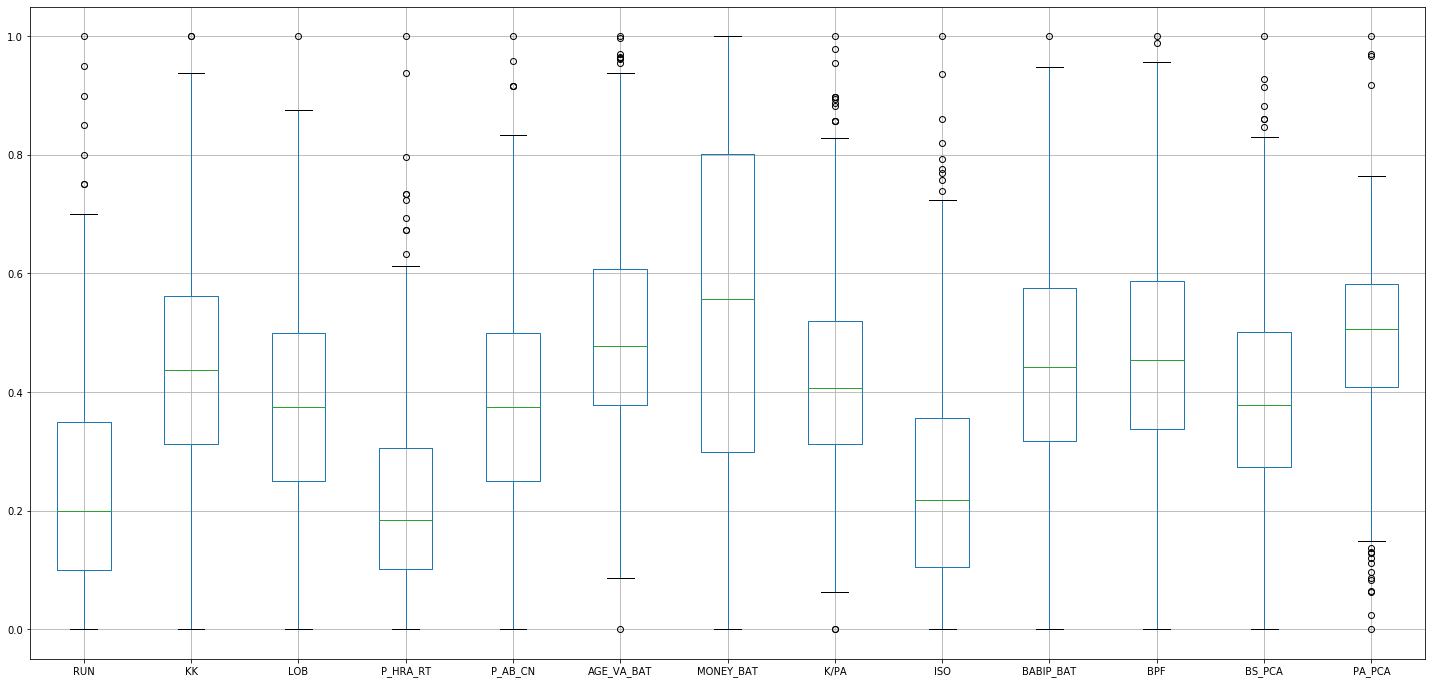

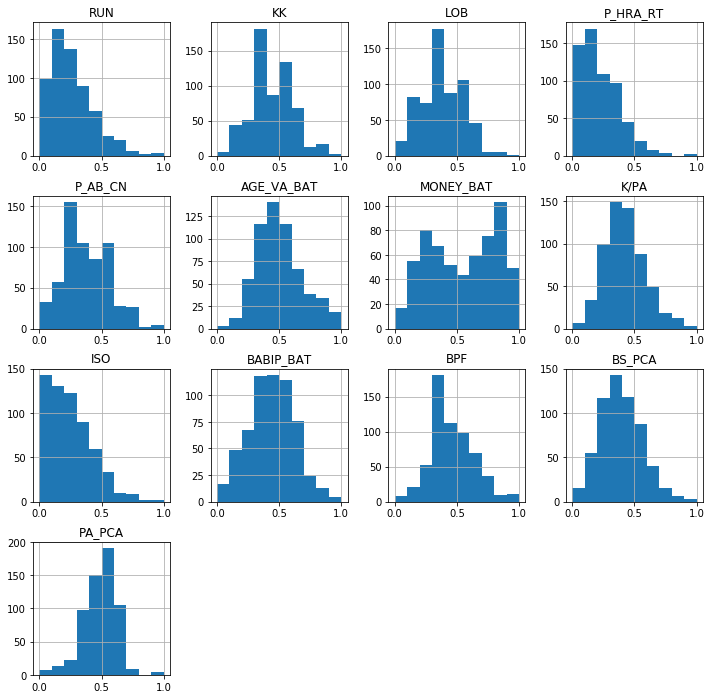

In [65]:
feature.boxplot(figsize = (25, 12))
feature.hist(figsize = (12, 12))

{'whiskers': [<matplotlib.lines.Line2D at 0x1eb07e45748>,
 'caps': [<matplotlib.lines.Line2D at 0x1eb07e71e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1eb07e45948>],
 'medians': [<matplotlib.lines.Line2D at 0x1eb07e7bf08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1eb07e7bfc8>],
 'means': []}

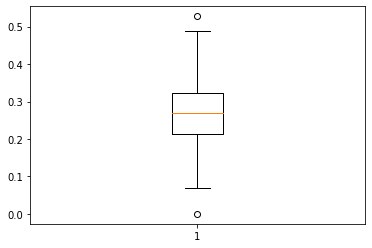

In [60]:
plt.boxplot(target)

In [68]:
feature.corr(method = "pearson")

,RUN,KK,LOB,P_HRA_RT,P_AB_CN,AGE_VA_BAT,MONEY_BAT,K/PA,ISO,BABIP_BAT,BPF,BS_PCA,PA_PCA
RUN,1.000000,-0.129679,0.228052,0.762984,0.655648,-0.022082,0.033492,-0.348057,0.580180,0.585124,0.131821,0.822061,-0.741147
KK,-0.129679,1.000000,0.078802,-0.109442,-0.045950,-0.024925,0.024468,0.930427,-0.043525,0.051556,0.094650,-0.178666,-0.076464
LOB,0.228052,0.078802,1.000000,0.216299,0.630542,-0.005499,0.008167,-0.179680,-0.048036,0.488199,-0.043025,0.412357,-0.668417
P_HRA_RT,0.762984,-0.109442,0.216299,1.000000,0.621510,0.070161,-0.016228,-0.291280,0.249562,0.607219,0.044980,0.610214,-0.611050
P_AB_CN,0.655648,-0.045950,0.630542,0.621510,1.000000,0.029681,-0.015645,-0.299812,0.190336,0.654995,0.035503,0.638720,-0.764090
AGE_VA_BAT,-0.022082,-0.024925,-0.005499,0.070161,0.029681,1.000000,-0.093106,-0.034807,-0.057971,-0.021935,0.026981,-0.092264,-0.001790
MONEY_BAT,0.033492,0.024468,0.008167,-0.016228,-0.015645,-0.093106,1.000000,0.017561,0.060827,-0.035447,0.180590,0.050065,-0.014302
K/PA,-0.348057,0.930427,-0.179680,-0.291280,-0.299812,-0.034807,0.017561,1.000000,-0.145986,-0.155129,0.068374,-0.392391,0.255196
ISO,0.580180,-0.043525,-0.048036,0.249562,0.190336,-0.057971,0.060827,-0.145986,1.000000,0.159256,0.246497,0.620143,-0.342811
BABIP_BAT,0.585124,0.051556,0.488199,0.607219,0.654995,-0.021935,-0.035447,-0.155129,0.159256,1.000000,0.029457,0.713396,-0.670889


In [88]:
data = go.Scatter3d(x = feature["P_HIT_CN"], y = feature["P_HRA_RT"], z = feature["P_AB_CN"], mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

KeyError: 'P_HIT_CN'

In [69]:
# Find Feature - GBRT
trainFeature = feature.loc[0:feature.shape[0]-120]
trainTarget = target.loc[0:feature.shape[0]-120]

validFeature = feature.loc[feature.shape[0]-120 : feature.shape[0]-20]
validTarget = target.loc[feature.shape[0]-120 : feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)

tree = GradientBoostingRegressor(max_depth = 5,learning_rate = 0.1, n_estimators = 500, subsample = 0.8)
tree.fit(trainFeature, trainTarget)

tree.score(testFeature, testTarget)



-0.42145613167180684

In [107]:
#param_grid = {"max_depth" : [2, 3, 4, 5],
#              "learning_rate" : [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
#              "n_estimators"  : [100, 150, 200, 250, 300, 350, 400, 450, 500],
#              "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
#              "warm_start" : [True, False]}

#grid = GridSearchCV(tree, param_grid, cv = 3)
#grid.fit(trainFeature, trainTarget)
#grid.score(validFeature, validTarget)

#grid.best_score_
#grid.best_params_

In [70]:
# Find Feature - GBRT

result = tree.predict(testFeature)
result = result.reshape(testTarget.shape[0])

result.mean()


0.26423749994422263

In [71]:
testTarget.mean()

0.2830805126315159

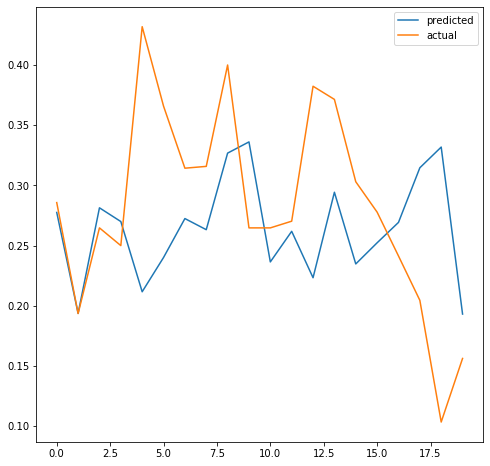

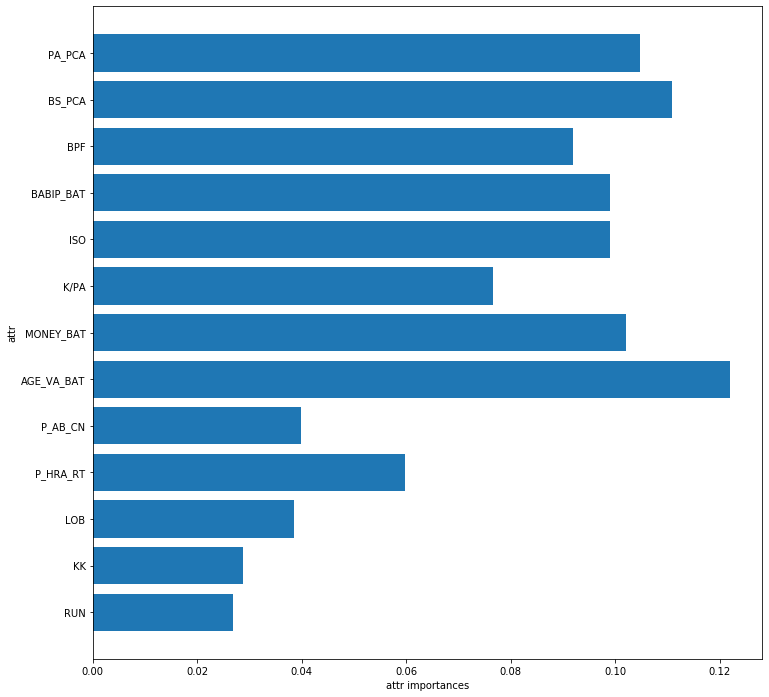

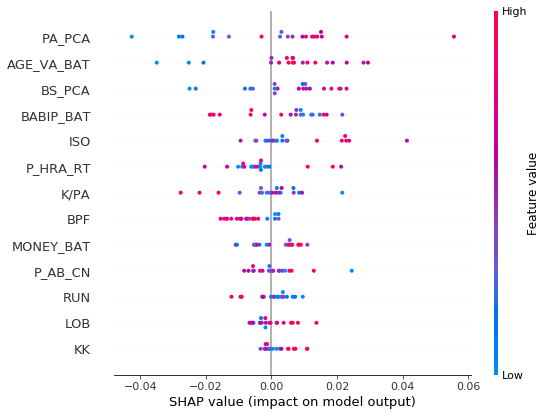

In [72]:
# Find Feature - GBRT

plt.figure(figsize = (8, 8))
plt.plot(result, label = "predicted")
plt.plot(testTarget, label = "actual")
plt.legend()

n_features = trainFeature.shape[1]

plt.figure(figsize = (12, 12))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), testFeature.columns)
plt.xlabel("attr importances")
plt.ylabel("attr")
plt.ylim(-1, n_features)
plt.show()

explainer = shap.TreeExplainer(tree, trainFeature)
shap_values = explainer.shap_values(testFeature, check_additivity = False)
shap.summary_plot(shap_values, testFeature)


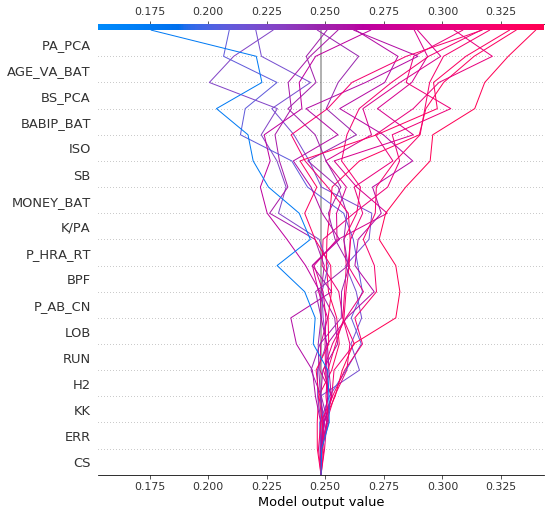

In [61]:
ind = list(range(0, 20))
shap.decision_plot(explainer.expected_value, shap_values[ind, :], testFeature.loc[ind])

In [764]:
shap.initjs()
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind, :], testFeature.loc[ind])

In [806]:
data = go.Scatter3d(x = HH["OPS"], y = HH["XR"], z = HH["RUN"], mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

'temp-plot.html'

In [834]:
data = go.Scatter3d(x = HH_TSNE[0], y = HH["BS_PCA"], z = target, mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

'temp-plot.html'

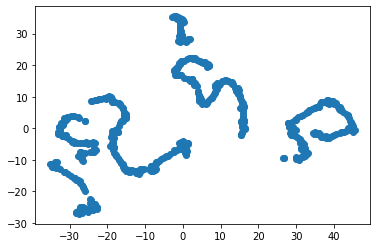

In [917]:
# t-SNE

tsne = TSNE(learning_rate = 300)
transform = pd.DataFrame(tsne.fit_transform(HH.drop(["BS_PCA"], axis = "columns")))
transform[2] = HH["BS_PCA"]

res = scaler.fit(transform)
res = scaler.transform(transform)
HH_TSNE = pd.DataFrame(res)
HH_TSNE

plt.scatter(transform[0], transform[1])
plt.show()